# Image generation


In [71]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

from vgg16_avg import VGG16_Avg

In [56]:
from bcolz_array_iterator import BcolzArrayIterator

In [3]:
limit_mem()

In [4]:
path = '/data/jhoward/imagenet/full/'
dpath = '/data/jhoward/fast/imagenet/full/'

In [5]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [6]:
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [7]:
arr_lr = bcolz.open(dpath+'trn_resized_72_r.bc')
arr_hr = bcolz.open(path+'results/trn_resized_288_r.bc')

In [8]:
parms = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}

In [9]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Convolution2D(filters, size, size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x) if act else x

In [10]:
def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return merge([x, ip], mode='sum')

In [11]:
def up_block(x, filters, size):
    x = keras.layers.UpSampling2D()(x)
    x = Convolution2D(filters, size, size, border_mode='same')(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x)

In [83]:
def get_model(arr):
    inp=Input(arr.shape[1:])
    x=conv_block(inp, 64, 9, (1,1))
    for i in range(4): x=res_block(x)
    x=up_block(x, 64, 3)
    x=up_block(x, 64, 3)
    x=Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
    outp=Lambda(lambda x: (x+1)*127.5)(x)
    return inp,outp

In [ ]:
inp,outp=get_model(arr_lr)

In [13]:
shp = arr_hr.shape[1:]

vgg_inp=Input(shp)
vgg= VGG16(include_top=False, input_tensor=Lambda(preproc)(vgg_inp))
for l in vgg.layers: l.trainable=False

In [14]:
def get_outp(m, ln): return m.get_layer(f'block{ln}_conv2').output
vgg_content = Model(vgg_inp, [get_outp(vgg, o) for o in [1,2,3]])
vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp)

In [15]:
def mean_sqr_b(diff): 
    dims = list(range(1,K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)

In [16]:
w=[0.1, 0.8, 0.1]
def content_fn(x): 
    res = 0; n=len(w)
    for i in range(n): res += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return res

In [17]:
m_sr = Model([inp, vgg_inp], Lambda(content_fn)(vgg1+vgg2))
m_sr.compile('adam', 'mae')

In [63]:
def train(bs, niter=10):
    targ = np.zeros((bs, 1))
    bc = BcolzArrayIterator(arr_hr, arr_lr, batch_size=bs)
    for i in range(niter):
        hr,lr = next(bc)
        m_sr.train_on_batch([lr[:bs], hr[:bs]], targ)

In [64]:
its = len(arr_hr)//16; its

62277

In [34]:
%time train(16, 18000)

CPU times: user 2h 22min 35s, sys: 1h 11min 5s, total: 3h 33min 40s
Wall time: 4h 28min 40s


In [35]:
K.set_value(m_sr.optimizer.lr, 1e-4)
train(16, 18000)

In [36]:
top_model = Model(inp, outp)

In [37]:
p = top_model.predict(arr_lr[:20])

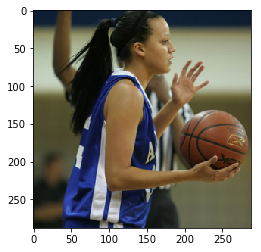

In [53]:
idx=4
plt.imshow(arr_hr[idx].astype('uint8'));

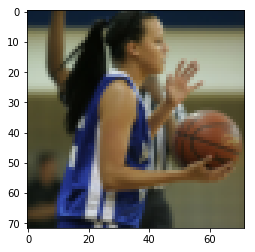

In [54]:
plt.imshow(arr_lr[idx].astype('uint8'));

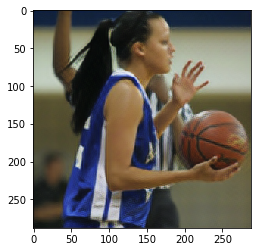

In [55]:
plt.imshow(p[idx].astype('uint8'));

In [ ]:
inp,outp=get_model(arr_hr)
model_hr = Model(inp, outp)
copy_weights(top_model.layers, model_hr.layers)

In [78]:
p = model_hr.predict(arr_hr[idx:idx+1])

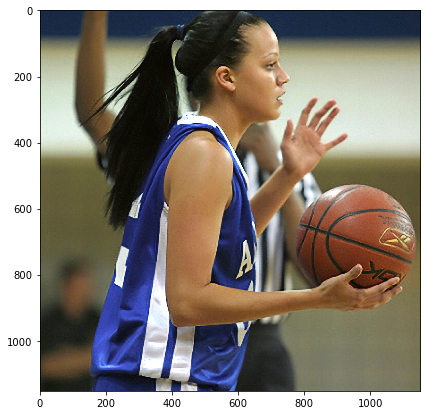

In [81]:
plt.figure(figsize=(7,7))
plt.imshow(p[0].astype('uint8'));

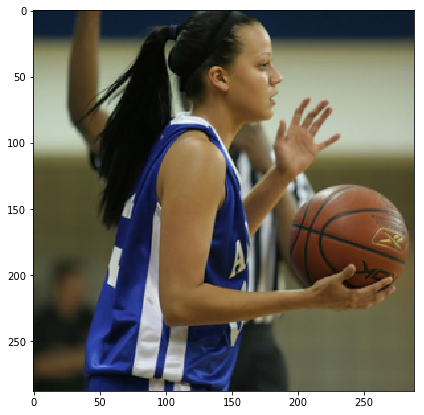

In [82]:
plt.figure(figsize=(7,7))
plt.imshow(arr_hr[idx].astype('uint8'));

In [40]:
top_model.save_weights(dpath+'sr_final.h5')

In [198]:
top_model.load_weights(dpath+'top_final.h5')